# Example 1: Using GSN to estimate signal and noise

#### GSN is a method that estimates signal and noise distributions that underlie neural response measurements.

The purpose of this Example 1 is to guide the user through basic calls to GSN, using a representative, small-scale test dataset. The goal is to show the full process of calling GSN, inspecting noise ceiling (ncsnr) values, visualizing signal and noise covariance matrices, and performing PCA.

Users encountering bugs, unexpected outputs, or other issues regarding GSN shouldn't hesitate to raise an issue on GitHub: https://github.com/cvnlab/GSN/issues

The example data has dimensionality 100 voxels x 200 conditions x 3 trials. The data are from an fMRI experiment measuring responses to auditory sentences. The values reflect fMRI response amplitudes in percent BOLD signal change units. The voxels are taken from a brain region in the left hemisphere. 


In [17]:
import os
from os.path import join, exists, split
import sys

sys.path.append(f'{os.getcwd()}/../')
from gsn.perform_gsn import perform_gsn

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import urllib.request

import traceback
import pdb


In [18]:
# get path to the directory to which GSN was installed
homedir = split(os.getcwd())[0]

# create directory for saving data
datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

# create directory for saving outputs from example 1
outputdir = join(homedir,'examples','example1outputs')

print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example1 outputs:\n\t{outputdir}\n')

directory to save example dataset:
	/Users/jacobprince/KonkLab Dropbox/Jacob Prince/DevBoxSync/Sandbox/GSN/examples/data

directory to save example1 outputs:
	/Users/jacobprince/KonkLab Dropbox/Jacob Prince/DevBoxSync/Sandbox/GSN/examples/example1outputs



In [19]:
# download example dataset from GSN OSF repository
datafn = join(datadir,'exampledata.mat')

# to save time, we'll skip the download if the example dataset already exists on disk
if not exists(datafn):

    print(f'Downloading example dataset and saving to:\n{datafn}')

    dataurl = 'https://osf.io/download/utfpq/'

    # download the .mat file to the specified directory
    urllib.request.urlretrieve(dataurl, datafn)

# load struct containing example dataset
X = sio.loadmat(datafn)


In [20]:
# data contains 100 voxels x 200 conditions x 3 trials.
# The values are fMRI response amplitudes in percent signal change units.

# Perform GSN.
# We explicitly set the wantshrinkage flag to true.
results = perform_gsn(X['data'], {'wantshrinkage': True})


Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.


In [21]:
# We have several outputs in results:
# mnN is the mean of the noise distribution
# cN is the raw estimate of the covariance of the noise distribution 
# cNb is the final estimate of the covariance of the noise distribution
# mnS is the mean of the signal distribution
# cS is the raw estimate of the covariance of the signal distribution 
# cSb is the final estimate of the covariance of the signal distribution
# shrinklevelN is the shrinkage fraction used when estimating the noise distribution
# shrinklevelD is the shrinkage fraction used when estimating the data distribution
# ncsnr is the noise ceiling snr for each voxel (signal sd divided by noise sd)

In [22]:
# Notice that the noise covariance estimate involved some shrinkage:
print(results['shrinklevelN'])


0.9400000000000001


In [23]:
# Notice that the data covariance estimate involved some shrinkage:
print(results['shrinklevelD'])


0.72


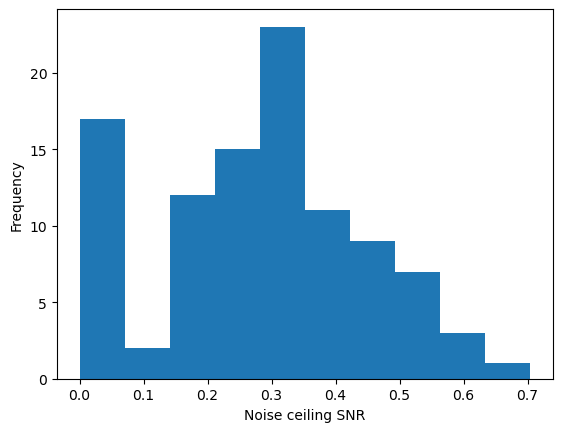

In [24]:
# Let's take a look at ncsnr

plt.figure()
plt.hist(results['ncsnr'])
plt.xlabel('Noise ceiling SNR')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Things look good as there are plenty of voxels with positive ncsnr.
# Some ncsnr values are 0. This indicates that these voxels apparently
# do not seem to have any signal.

# Let's visualize the covariance estimates

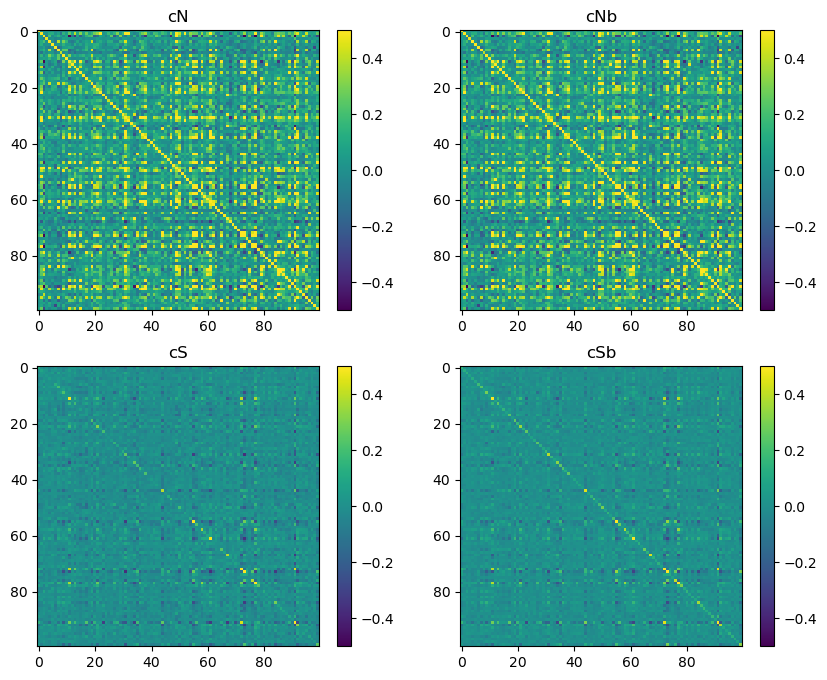

In [26]:
# Set range for color limits
rng = [-0.5, 0.5]

# Visualize the covariance estimates
plt.figure(figsize=(10, 8))

# Noise covariance estimate
plt.subplot(2, 2, 1)
plt.imshow(results['cN'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cN')
plt.axis('tight')

# Final noise covariance estimate
plt.subplot(2, 2, 2)
plt.imshow(results['cNb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cNb')
plt.axis('tight')

# Signal covariance estimate
plt.subplot(2, 2, 3)
plt.imshow(results['cS'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cS')
plt.axis('tight')

# Final signal covariance estimate
plt.subplot(2, 2, 4)
plt.imshow(results['cSb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cSb')
plt.axis('tight')

plt.show()

In [27]:
# Notice that the diagonals of the noise covariance are stronger than the diagonals 
# of the signal covariance. This means the noise is larger in magnitude than the
# signal. This is consistent with our earlier look at ncsnr.
#
# Also, notice final covariance estimates (cNb and cSb) look similar to 
# the raw covariance estimates (cN and cS).

# However, there are some differences:
print(np.corrcoef(results['cN'].reshape(-1),
                  results['cNb'].reshape(-1))[0,1])

print(np.corrcoef(results['cS'].reshape(-1),
                  results['cSb'].reshape(-1))[0,1])


0.9999512147977802
0.9549890989731675


In [28]:
# PERFORM PCA

# Define the function to convert covariance to correlation 
def convert_covariance_to_correlation(cov):
    d = np.sqrt(np.diag(cov))
    corr = cov / np.outer(d, d)
    np.fill_diagonal(corr, 1)
    return corr

In [29]:
# Define a function to compute effective dimensionality
def ed_fun(x):
    return np.sum(x) ** 2 / np.sum(x ** 2)

In [30]:
# Perform SVD on the correlation matrices
uS, sS, vS = np.linalg.svd(convert_covariance_to_correlation(results['cSb']), full_matrices=False)
uN, sN, vN = np.linalg.svd(convert_covariance_to_correlation(results['cNb']), full_matrices=False)

In [31]:
# Note that svd can be performed on the original covariance (as opposed to
# the correlation version). The results will be different, and reflect a 
# different interpretation. By converting to correlation, we are giving
# each voxel equal influence in the signal correlation matrix and in the 
# noise correlation matrix, even though there may be variations in the 
# signal and noise variances associated with different voxels in the 
# original (non-normalized) data.

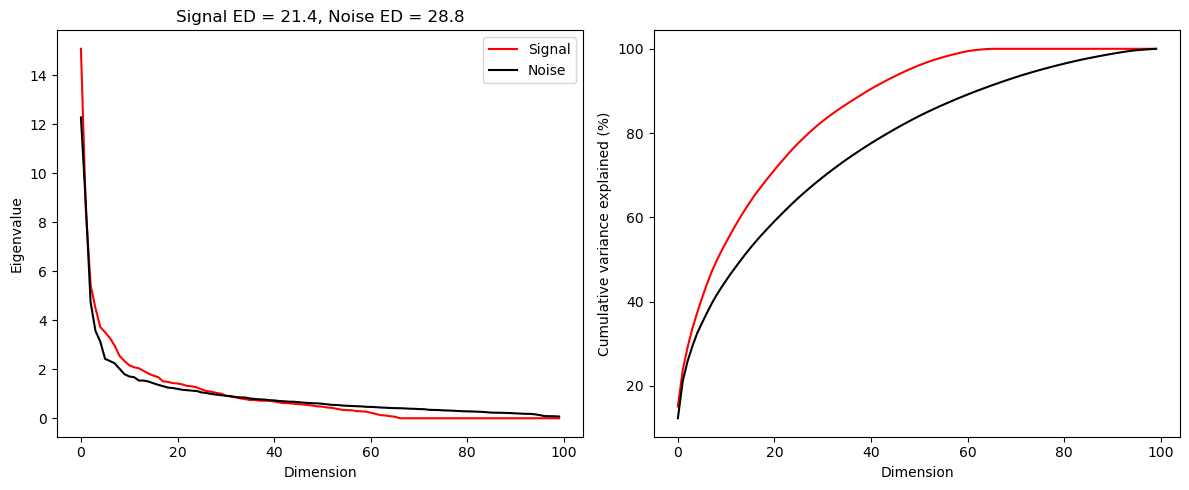

In [32]:
# Visualize the eigenspectra
plt.figure(figsize=(12, 5))

# Eigenspectra plot
plt.subplot(1, 2, 1)
plt.plot(sS, 'r-', label='Signal')
plt.plot(sN, 'k-', label='Noise')
plt.title(f'Signal ED = {ed_fun(sS):.1f}, Noise ED = {ed_fun(sN):.1f}')
plt.xlabel('Dimension')
plt.ylabel('Eigenvalue')
plt.legend()

# Cumulative variance explained plot
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(sS) / np.sum(sS) * 100, 'r-', label='Signal')
plt.plot(np.cumsum(sN) / np.sum(sN) * 100, 'k-', label='Noise')
plt.xlabel('Dimension')
plt.ylabel('Cumulative variance explained (%)')

plt.tight_layout()
plt.show()

# Notice that the noise has higher dimensionality than the signal.
